# 載入所需套件

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.covariance import LedoitWolf
import statsmodels.api as sm
from datetime import datetime
from tqdm import tqdm

%matplotlib inline

# 定義函數

In [2]:
def extract_corr_from_cov(cov_matrix):
    D_inv_matrix=np.linalg.inv(np.diag(np.sqrt(np.diag(cov_matrix))))
    corr_matrix=D_inv_matrix.dot(cov_matrix).dot(D_inv_matrix)
    
    return corr_matrix

In [3]:
def buckle_BR_const(N,rho):
    BR_ratio=N/(1+rho*(N-1))
    
    return BR_ratio

# 抓取股價資料

In [4]:
start=datetime(2017,1,1)
end=datetime.now().date()
tickers=['INTC','AAPL','NVDA','WFC','JPM','USB','SPY','XLK','XLF']
stock_list=['INTC','AAPL','NVDA','WFC','JPM','USB']
tech_list=['INTC','AAPL','NVDA']
fin_list=['WFC','JPM','USB']
adj_close={}

for ticker in tqdm(tickers):
    adj_close[ticker]=pdr.DataReader(ticker,'yahoo',start,end)['Adj Close']

adj_close_df=pd.DataFrame(adj_close)
adj_close_df.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  1.70s/it]


,INTC,AAPL,NVDA,WFC,JPM,USB,SPY,XLK,XLF
Date,,,,,,,,,
2017-01-03,33.292320,27.548414,100.800652,49.126301,78.289482,46.466454,209.785889,46.279709,21.802677
2017-01-04,33.119495,27.517582,103.152428,49.170162,78.433876,46.809586,211.033981,46.440964,21.978876
2017-01-05,33.064915,27.657520,100.533859,48.406956,77.711906,46.024002,210.866318,46.516846,21.756306
2017-01-06,33.183170,27.965857,101.877731,48.284138,77.720917,46.321983,211.620728,46.858326,21.830500
2017-01-09,33.301426,28.222006,106.008179,47.582344,77.775063,46.114304,210.922211,46.848831,21.682116


In [5]:
return_df=adj_close_df.pct_change().dropna()
return_df.head()

,INTC,AAPL,NVDA,WFC,JPM,USB,SPY,XLK,XLF
Date,,,,,,,,,
2017-01-04,-0.005191,-0.001119,0.023331,0.000893,0.001844,0.007385,0.005949,0.003484,0.008082
2017-01-05,-0.001648,0.005085,-0.025385,-0.015522,-0.009205,-0.016783,-0.000794,0.001634,-0.010127
2017-01-06,0.003576,0.011148,0.013367,-0.002537,0.000116,0.006474,0.003578,0.007341,0.003410
2017-01-09,0.003564,0.009159,0.040543,-0.014535,0.000697,-0.004483,-0.003301,-0.000203,-0.006797
2017-01-10,-0.001912,0.001009,-0.007550,0.007006,0.002901,0.002937,0.000000,0.000203,0.002139


# 不避險

In [6]:
#Calculate Ledoit-Wolf estimator
lw_cov=LedoitWolf().fit(return_df[stock_list]).covariance_ 
lw_cov

array([[0.00049969, 0.0002577 , 0.00038323, 0.00022558, 0.00022954,
        0.00020965],
       [0.0002577 , 0.00039728, 0.00035875, 0.00019039, 0.00020011,
        0.00018009],
       [0.00038323, 0.00035875, 0.00090515, 0.00024363, 0.00025031,
        0.00022243],
       [0.00022558, 0.00019039, 0.00024363, 0.00048355, 0.00035824,
        0.00037075],
       [0.00022954, 0.00020011, 0.00025031, 0.00035824, 0.00039507,
        0.00034045],
       [0.00020965, 0.00018009, 0.00022243, 0.00037075, 0.00034045,
        0.00041064]])

In [7]:
corr_matrix=extract_corr_from_cov(lw_cov)
corr_matrix

array([[1.        , 0.57837233, 0.56982902, 0.45891827, 0.51662767,
        0.46281917],
       [0.57837233, 1.        , 0.59824141, 0.43437694, 0.50511159,
        0.44587291],
       [0.56982902, 0.59824141, 1.        , 0.3682478 , 0.41858853,
        0.36484119],
       [0.45891827, 0.43437694, 0.3682478 , 1.        , 0.81962554,
        0.83201127],
       [0.51662767, 0.50511159, 0.41858853, 0.81962554, 1.        ,
        0.84525256],
       [0.46281917, 0.44587291, 0.36484119, 0.83201127, 0.84525256,
        1.        ]])

Text(0.5, 1.0, 'Ledoit-Wolf Pairwise Correlation')

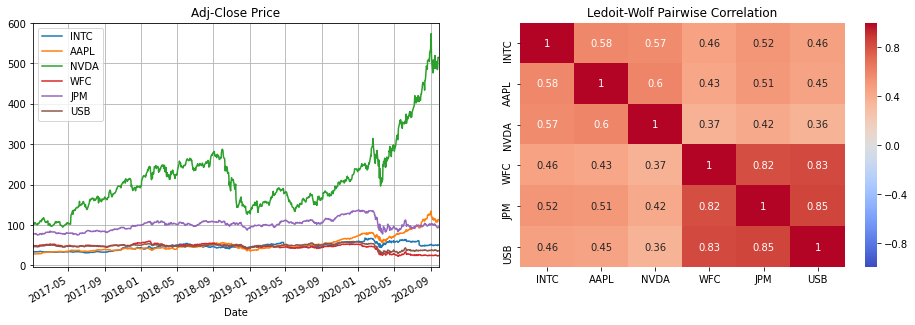

In [8]:
fig,axes=plt.subplots(1,2,figsize=(16,5))
adj_close_df[stock_list].plot(ax=axes[0])
axes[0].set_title('Adj-Close Price',fontsize=12)
axes[0].grid()
sns.heatmap(corr_matrix,ax=axes[1],annot=True,vmin=-1,vmax=1,cmap='coolwarm',xticklabels=stock_list,yticklabels=stock_list)
axes[1].set_title('Ledoit-Wolf Pairwise Correlation',fontsize=12)

In [9]:
avg_corr=np.mean(corr_matrix[np.triu_indices_from(corr_matrix,k=1)])
print('Average pairwise correlation : {:6.4f}'.format(avg_corr))

Average pairwise correlation : 0.5479


# Beta避險

In [10]:
market_return=return_df['SPY'].values
residual={}

for stock in stock_list:
    model=sm.OLS(return_df[stock].values,market_return)
    results=model.fit()
    residual[stock]=results.resid

residual_df=pd.DataFrame(residual)
#Calculate Ledoit-Wolf estimator
lw_cov=LedoitWolf().fit(residual_df).covariance_
lw_cov

array([[ 2.45091120e-04,  1.93562970e-05,  7.02858496e-05,
        -2.41530803e-05, -1.43260299e-05, -2.47903950e-05],
       [ 1.93562970e-05,  1.55829729e-04,  5.41519097e-05,
        -5.26231986e-05, -3.72074671e-05, -4.80469534e-05],
       [ 7.02858496e-05,  5.41519097e-05,  4.94887931e-04,
        -7.52435530e-05, -6.10635508e-05, -7.68908219e-05],
       [-2.41530803e-05, -5.26231986e-05, -7.52435530e-05,
         2.18781051e-04,  1.08816225e-04,  1.30825708e-04],
       [-1.43260299e-05, -3.72074671e-05, -6.10635508e-05,
         1.08816225e-04,  1.42509053e-04,  1.06280129e-04],
       [-2.47903950e-05, -4.80469534e-05, -7.68908219e-05,
         1.30825708e-04,  1.06280129e-04,  1.76303696e-04]])

In [11]:
corr_matrix=extract_corr_from_cov(lw_cov)
corr_matrix

array([[ 1.        ,  0.09904518,  0.20181372, -0.1043047 , -0.07665506,
        -0.11925839],
       [ 0.09904518,  1.        ,  0.19500026, -0.28500156, -0.24967998,
        -0.28987448],
       [ 0.20181372,  0.19500026,  1.        , -0.22867096, -0.22993622,
        -0.26030971],
       [-0.1043047 , -0.28500156, -0.22867096,  1.        ,  0.6162651 ,
         0.66612776],
       [-0.07665506, -0.24967998, -0.22993622,  0.6162651 ,  1.        ,
         0.67050209],
       [-0.11925839, -0.28987448, -0.26030971,  0.66612776,  0.67050209,
         1.        ]])

Text(0.5, 1.0, 'Ledoit-Wolf Pairwise Correlation')

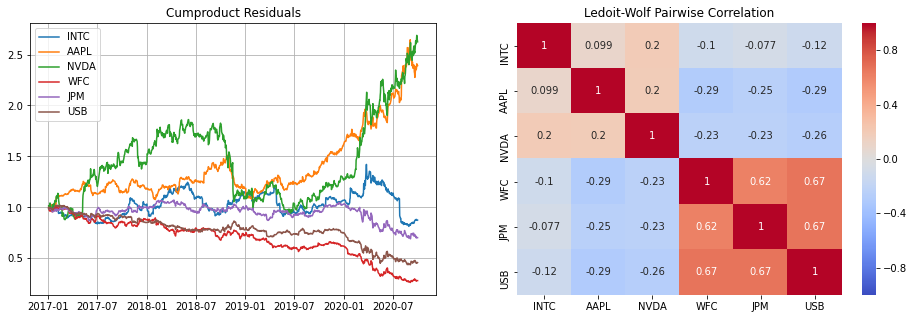

In [12]:
fig,axes=plt.subplots(1,2,figsize=(16,5))
axes[0].plot(return_df.index,(1+residual_df).cumprod())
axes[0].set_title('Cumproduct Residuals',fontsize=12)
axes[0].legend(stock_list)
axes[0].grid()
sns.heatmap(corr_matrix,ax=axes[1],annot=True,vmin=-1,vmax=1,cmap='coolwarm',xticklabels=stock_list,yticklabels=stock_list)
axes[1].set_title('Ledoit-Wolf Pairwise Correlation',fontsize=12)

In [13]:
avg_corr=np.mean(corr_matrix[np.triu_indices_from(corr_matrix,k=1)])
print('Average pairwise correlation : {:6.4f}'.format(avg_corr))

Average pairwise correlation : 0.0403


# 行業避險

In [14]:
market_return=return_df['SPY'].values
tech_market_return=return_df['XLK'].values
fin_market_return=return_df['XLF'].values
residual={}

#Calculate market beta of tech-sector benchmark
model=sm.OLS(tech_market_return,market_return)
results=model.fit()
tech_sector_excess=results.resid
#Calculate market beta of fin-sector benchmark
model=sm.OLS(fin_market_return,market_return)
results=model.fit()
fin_sector_excess=results.resid


for stock in tech_list:
    #Calculate market betas for tech-sector stocks
    model=sm.OLS(return_df[stock],market_return)
    results=model.fit()
    residuals_market=results.resid
    #Calculate sector beta for previous residuals
    model=sm.OLS(residuals_market,tech_sector_excess)
    results=model.fit()
    #Get final residual
    residual[stock]=results.resid
    
    
for stock in fin_list:
    #Calculate market betas for tech-sector stocks
    model=sm.OLS(return_df[stock],market_return)
    results=model.fit()
    residuals_market=results.resid
    #Calculate sector beta for previous residuals
    model=sm.OLS(residuals_market,fin_sector_excess)
    results=model.fit()
    #Get final residual
    residual[stock]=results.resid

residual_df=pd.DataFrame(residual)
#Calculate Ledoit-Wolf estimator
lw_cov=LedoitWolf().fit(residual_df).covariance_
lw_cov

array([[ 2.09406410e-04, -2.40140466e-05,  1.08047407e-05,
         5.32149990e-06,  7.45923911e-06,  3.69010807e-06],
       [-2.40140466e-05,  9.13794344e-05, -2.89963235e-05,
        -1.31151330e-06,  2.37315304e-06,  8.38685287e-07],
       [ 1.08047407e-05, -2.89963235e-05,  3.74270686e-04,
        -5.20266318e-06, -6.84930333e-06, -1.00607830e-05],
       [ 5.32149990e-06, -1.31151330e-06, -5.20266318e-06,
         9.25909151e-05, -4.66675265e-06,  1.94816166e-05],
       [ 7.45923911e-06,  2.37315304e-06, -6.84930333e-06,
        -4.66675265e-06,  3.61237683e-05,  4.04042748e-06],
       [ 3.69010807e-06,  8.38685287e-07, -1.00607830e-05,
         1.94816166e-05,  4.04042748e-06,  7.39078020e-05]])

In [15]:
corr_matrix=extract_corr_from_cov(lw_cov)
corr_matrix

array([[ 1.        , -0.17359856,  0.03859459,  0.03821685,  0.0857636 ,
         0.0296619 ],
       [-0.17359856,  1.        , -0.15679268, -0.01425819,  0.04130522,
         0.01020539],
       [ 0.03859459, -0.15679268,  1.        , -0.02794786, -0.05890565,
        -0.06049141],
       [ 0.03821685, -0.01425819, -0.02794786,  1.        , -0.08069267,
         0.23550258],
       [ 0.0857636 ,  0.04130522, -0.05890565, -0.08069267,  1.        ,
         0.0781962 ],
       [ 0.0296619 ,  0.01020539, -0.06049141,  0.23550258,  0.0781962 ,
         1.        ]])

Text(0.5, 1.0, 'Ledoit-Wolf Pairwise Correlation')

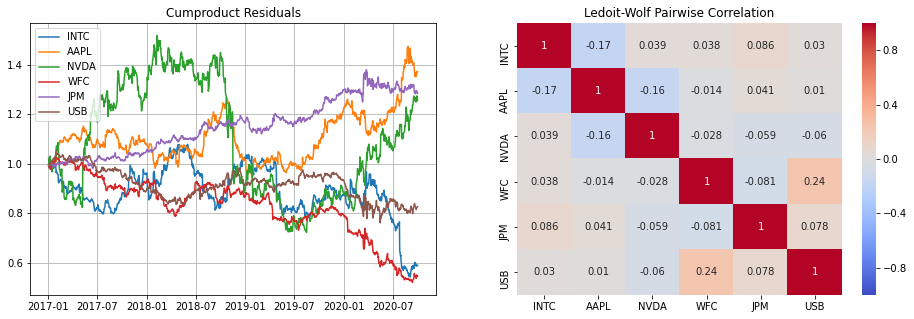

In [16]:
fig,axes=plt.subplots(1,2,figsize=(16,5))
axes[0].plot(return_df.index,(1+residual_df).cumprod())
axes[0].set_title('Cumproduct Residuals',fontsize=12)
axes[0].legend(stock_list)
axes[0].grid()
sns.heatmap(corr_matrix,ax=axes[1],annot=True,vmin=-1,vmax=1,cmap='coolwarm',xticklabels=stock_list,yticklabels=stock_list)
axes[1].set_title('Ledoit-Wolf Pairwise Correlation',fontsize=12)

In [17]:
avg_corr=np.mean(corr_matrix[np.triu_indices_from(corr_matrix,k=1)])
print('Average pairwise correlation : {:6.4f}'.format(avg_corr))

Average pairwise correlation : -0.0010


# 計算Effective Breadth

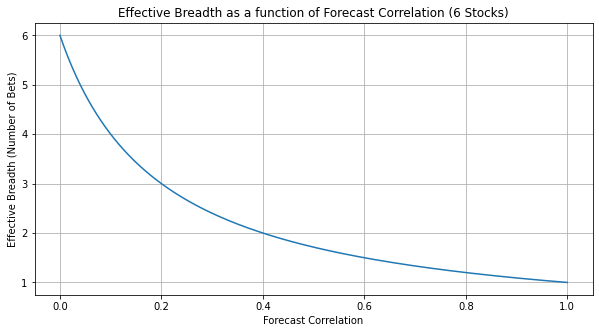

In [18]:
corr=np.linspace(0,1,500)
fig,ax=plt.subplots(1,figsize=(10,5))
ax.plot(corr,buckle_BR_const(6,corr))
ax.set_title('Effective Breadth as a function of Forecast Correlation (6 Stocks)',fontsize=12)
ax.set_xlabel('Forecast Correlation',fontsize=10)
ax.set_ylabel('Effective Breadth (Number of Bets)',fontsize=10)
ax.grid()